# **Elliptic++ Actors (Wallet Addresses) Dataset**

***Note: "Actor" refers to a Bitcoin wallet address***

---
---


Released by: Youssef Elmougy, Ling Liu



School of Computer Science, Georgia Institute of Technology

Contact: yelmougy3@gatech.edu


---

Github Repository: [https://www.github.com/git-disl/EllipticPlusPlus](https://www.github.com/git-disl/EllipticPlusPlus)


If you use our dataset in your work, please cite our paper:





>> Youssef Elmougy and Ling Liu. 2023. Demystifying Fraudulent Transactions and Illicit Nodes in the Bitcoin Network for Financial Forensics.

---



## [SETUP] Import libraries and csv files 

Download dataset from: [https://www.github.com/git-disl/EllipticPlusPlus](https://www.github.com/git-disl/EllipticPlusPlus)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp drive/My\ Drive/Elliptic++\ Dataset/wallets_features.csv ./
!cp drive/My\ Drive/Elliptic++\ Dataset/wallets_classes.csv ./
!cp drive/My\ Drive/Elliptic++\ Dataset/AddrAddr_edgelist.csv ./
!cp drive/My\ Drive/Elliptic++\ Dataset/AddrTx_edgelist.csv ./
!cp drive/My\ Drive/Elliptic++\ Dataset/TxAddr_edgelist.csv ./
!cp drive/My\ Drive/Elliptic++\ Dataset/wallets_features_classes_combined.csv ./

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.graph_objs as go 
import plotly.offline as py 
import math
from collections import Counter

!pip install -U ipython 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone 

import xgboost as xgb

In [ ]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 KB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 17.7 MB/s eta 0:00:00
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=4ad64e3b8b283172c1ae01f750cdea27fcc42eeef533a5a0428c77fa474f08d2
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatib

## Actors Dataset Overview


---

This section loads the 5 csv files (wallets_features, wallets_classes, AddrAddr_edgelist, AddrTx_edgelist, TxAddr_edgelist) and provides a quick overview of the dataset structure and features.

Load saved actors dataset csv files:

In [ ]:
print("\nActors features: \n")
df_wallets_features = pd.read_csv("wallets_features.csv")
df_wallets_features

print("\nActors Classes: \n")
df_wallets_classes = pd.read_csv("wallets_classes.csv")
df_wallets_classes

print("\nAddress-Address edgelist: \n") #Actor Interaction graph edgelist
df_AddrAddr_edgelist = pd.read_csv("AddrAddr_edgelist.csv")
df_AddrAddr_edgelist

print("\nAddress-Transaction edgelist: \n") #Address-Transaction graph edgelist
df_AddrTx_edgelist = pd.read_csv("AddrTx_edgelist.csv")
df_AddrTx_edgelist

print("\nTransaction-Address edgelist: \n") #Address-Transaction graph edgelist
df_TxAddr_edgelist = pd.read_csv("TxAddr_edgelist.csv")
df_TxAddr_edgelist

# combined features and classes csv files for convenience
df_wallets_features_classes_combined = pd.read_csv("wallets_features_classes_combined.csv")


Actors features: 



,address,Time step,num_txs_as_sender,num_txs_as receiver,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks,total_txs,first_sent_block,first_received_block,...,blocks_btwn_output_txs_min,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median
0,111112TykSw72ztDN2WJger4cynzWYC5w,25,0.0,1.0,439586.0,439586.0,0.0,1.0,0.0,439586.0,...,0.0,0.0,0.000000,0.0,0.0,24.0,1.0,1.0,1.0,1.0
1,1111DAYXhoxZx2tsRnzimfozo783x1yC2,25,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,439589.0,...,0.0,20164.0,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0
2,1111DAYXhoxZx2tsRnzimfozo783x1yC2,29,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,439589.0,...,0.0,20164.0,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0
3,1111DAYXhoxZx2tsRnzimfozo783x1yC2,39,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,439589.0,...,0.0,20164.0,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0
4,1111DAYXhoxZx2tsRnzimfozo783x1yC2,39,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,439589.0,...,0.0,20164.0,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268255,3R2Uw5MRdSSigp8AjfT7K5es6Hupm4qLSq,31,1.0,1.0,451684.0,451685.0,1.0,2.0,451685.0,451684.0,...,0.0,0.0,0.000000,0.0,0.0,3.0,1.0,1.0,1.0,1.0
1268256,3R2VBFbqHGC4bQ7b4ixN4jZTdv7RMbEYtf,44,0.0,1.0,477895.0,477895.0,0.0,1.0,0.0,477895.0,...,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1268257,3R2WFmRwbDeo3rMVVu5J3jjMxAuQYYWAid,9,0.0,1.0,407342.0,407342.0,0.0,1.0,0.0,407342.0,...,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1268258,3R2WTZGYLmbJQyoDSBftJsPRvF1mSEtkh6,3,0.0,1.0,395235.0,395235.0,0.0,1.0,0.0,395235.0,...,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0



Actors Classes: 



,address,class
0,111112TykSw72ztDN2WJger4cynzWYC5w,2
1,1111DAYXhoxZx2tsRnzimfozo783x1yC2,3
2,1111VHuXEzHaRCgXbVwojtaP7Co3QABb,2
3,111218KKkh1JJFRHbwM16AwCiVCc4m7he1,3
4,1115LWW3xsD9jT9VRY7viCN9S34RVAAuA,2
...,...,...
822937,3R2Uw5MRdSSigp8AjfT7K5es6Hupm4qLSq,3
822938,3R2VBFbqHGC4bQ7b4ixN4jZTdv7RMbEYtf,3
822939,3R2WFmRwbDeo3rMVVu5J3jjMxAuQYYWAid,3
822940,3R2WTZGYLmbJQyoDSBftJsPRvF1mSEtkh6,3



Address-Address edgelist: 



,input_address,output_address
0,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a,1GASxu5nMntiRKdVtTVRvEbP965G51bhHH
1,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a
2,13Lhad3SAmu2vqYg2dxbNcxH7LE77kJu2w,1GFdrdgtG34GChM8SMpMwcXFc4nYbH1A5G
3,1MAQQZn7EHP6J3erXByCciFiVcgS8ZhWqz,19q57SeCEzTnWrWVXA43nZzhSiXkYggh7c
4,1MAQQZn7EHP6J3erXByCciFiVcgS8ZhWqz,1Kk1NVYnCE8ALXDhgMM6HqTt1jDSvi6QBA
...,...,...
2868959,3MfN5to5K5be2RupWE8rjJHQ6V9L8ypWeh,3MfN5to5K5be2RupWE8rjJHQ6V9L8ypWeh
2868960,3DzbpEogZ1mn9FgCHcmzYPLDbV9GuxYHpi,38jMiiZs2C5n5MPkyc5pSA7wwW6H4p6hPa
2868961,34yD1sQg6C16aANCtibYXRj5NsX6tt4v5R,3G9b7hWZccuft1V4eGUcZqTZaxsqx699bM
2868962,1JERHCgwHG2Z7T3KjNpEwj3fJNX8vSfCX2,1JERHCgwHG2Z7T3KjNpEwj3fJNX8vSfCX2



Address-Transaction edgelist: 



,input_address,txId
0,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a,230325127
1,13Lhad3SAmu2vqYg2dxbNcxH7LE77kJu2w,230325139
2,1MAQQZn7EHP6J3erXByCciFiVcgS8ZhWqz,86875675
3,16zs5SVSyADh5WrLNbZbpRLsBsN5uEzgeK,230325147
4,1QJpwtUorBKPGUJkSyrRcBKTAHq4CXrdYh,230325154
...,...,...
477112,1HdnGvuc21Y4QfBEHUc3NFRJhGywdSFUb,157659046
477113,3MfN5to5K5be2RupWE8rjJHQ6V9L8ypWeh,157659306
477114,3DzbpEogZ1mn9FgCHcmzYPLDbV9GuxYHpi,157668825
477115,34yD1sQg6C16aANCtibYXRj5NsX6tt4v5R,125788182



Transaction-Address edgelist: 



,txId,output_address
0,230325127,1GASxu5nMntiRKdVtTVRvEbP965G51bhHH
1,230325127,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a
2,230325139,1GFdrdgtG34GChM8SMpMwcXFc4nYbH1A5G
3,86875675,19q57SeCEzTnWrWVXA43nZzhSiXkYggh7c
4,86875675,1Kk1NVYnCE8ALXDhgMM6HqTt1jDSvi6QBA
...,...,...
837119,157659306,3MfN5to5K5be2RupWE8rjJHQ6V9L8ypWeh
837120,157668825,38jMiiZs2C5n5MPkyc5pSA7wwW6H4p6hPa
837121,125788182,3G9b7hWZccuft1V4eGUcZqTZaxsqx699bM
837122,157670868,1JERHCgwHG2Z7T3KjNpEwj3fJNX8vSfCX2


Data structure for an example actor (address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K):

In [ ]:
print("\nwallets_features.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K\n")
df_wallets_features[df_wallets_features['address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K']

print("\nwallets_classes.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K\n")
df_wallets_classes[df_wallets_classes['address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K']

print("\nAddrAddr_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0\n")
df_AddrAddr_edgelist[(df_AddrAddr_edgelist['input_address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K') | (df_AddrAddr_edgelist['output_address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K')]

print("\nAddrTx_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0\n")
df_AddrTx_edgelist[df_AddrTx_edgelist['input_address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K']

print("\nTxAddr_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0\n")
df_TxAddr_edgelist[df_TxAddr_edgelist['output_address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K']


wallets_features.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K



,address,Time step,num_txs_as_sender,num_txs_as receiver,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks,total_txs,first_sent_block,first_received_block,...,blocks_btwn_output_txs_min,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median
1149250,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,23,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
1149251,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,23,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
1149252,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,23,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
1149253,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,23,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
1149254,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,24,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149666,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,32,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
1149667,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,32,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
1149668,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,32,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
1149669,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,32,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0



wallets_classes.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K



,address,class
745591,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,1



AddrAddr_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0



,input_address,output_address
1317522,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,131fHSzsK1eQJp7bC94JVWZqJ2JcdR5UfS
1317523,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
1317634,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,1FCw4XNAP6xeWMF4o3RaNENguE9qFumgpn
1317635,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
1317644,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
...,...,...
1592119,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
1592120,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
1592121,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,32ZkfqSGoxdx5UGo8YQp1tFhSv8R982Usk
1592122,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K



AddrTx_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0



,input_address,txId
235194,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,291338524
235250,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,88250674
235255,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,331553508
235256,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,331553509
239085,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,289228146
...,...,...
298647,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,355110135
298648,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,355110139
298649,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,343635736
298650,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,355110144



TxAddr_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0



,txId,output_address
431088,291338524,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
431200,88250674,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
431209,331553508,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
431212,331553509,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
436269,289228146,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
...,...,...
539069,355110135,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
539071,355110139,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
539073,343635736,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
539074,355110144,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K



Actors features --- class, 28 transaction-related features, 27 time-related features:

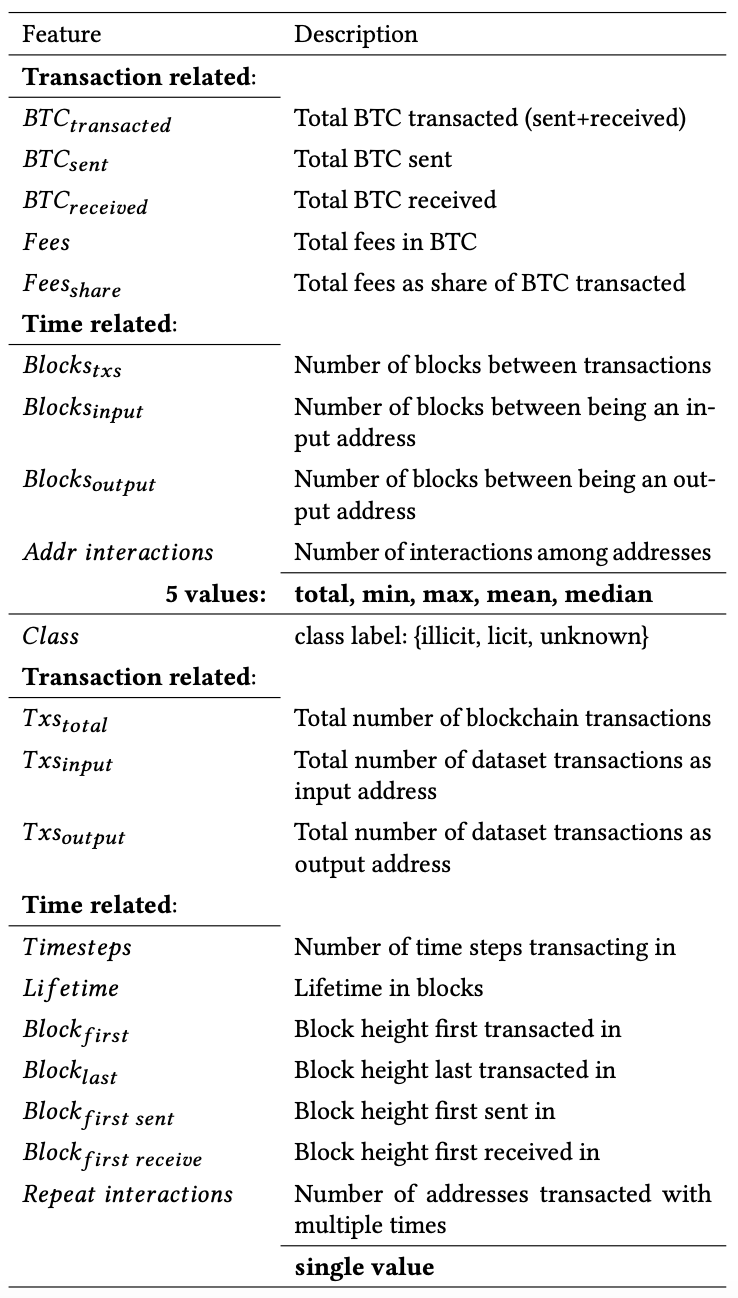


In [ ]:
df_wallets_features.columns

Index(['address', 'Time step', 'num_txs_as_sender', 'num_txs_as receiver',
       'first_block_appeared_in', 'last_block_appeared_in',
       'lifetime_in_blocks', 'total_txs', 'first_sent_block',
       'first_received_block', 'num_timesteps_appeared_in',
       'btc_transacted_total', 'btc_transacted_min', 'btc_transacted_max',
       'btc_transacted_mean', 'btc_transacted_median', 'btc_sent_total',
       'btc_sent_min', 'btc_sent_max', 'btc_sent_mean', 'btc_sent_median',
       'btc_received_total', 'btc_received_min', 'btc_received_max',
       'btc_received_mean', 'btc_received_median', 'fees_total', 'fees_min',
       'fees_max', 'fees_mean', 'fees_median', 'fees_as_share_total',
       'fees_as_share_min', 'fees_as_share_max', 'fees_as_share_mean',
       'fees_as_share_median', 'blocks_btwn_txs_total', 'blocks_btwn_txs_min',
       'blocks_btwn_txs_max', 'blocks_btwn_txs_mean', 'blocks_btwn_txs_median',
       'blocks_btwn_input_txs_total', 'blocks_btwn_input_txs_min',
       

## Dataset Statistics



---



This section gives overall actors data statistics.

Node labels:


```
1: illicit 
2: licit
3: unknown
```



Number of actors by class:

In [ ]:
df_wallets_classes['class'].value_counts()

3    557588
2    251088
1     14266
Name: class, dtype: int64

<BarContainer object of 3 artists>

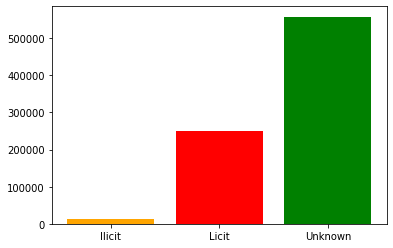

In [ ]:
actor_by_class = df_wallets_classes.groupby('class').count()
plt.bar(['Ilicit', 'Licit', 'Unknown'], actor_by_class['address'].values, color=['orange', 'r', 'g'] )

Number of input and output wallet addresses:

In [ ]:
print("\nUnique input addresses: ", len(df_AddrTx_edgelist['input_address'].unique()))

print("\nUnique output addresses: ", len(df_TxAddr_edgelist['output_address'].unique()))

print("\nTotal addresses: ", len(df_wallets_classes['address'].unique()))


Unique input addresses:  400212

Unique output addresses:  641043

Total addresses:  822942


Number of actors by time step:

Text(0.5, 1.0, 'Number of actors by time step')

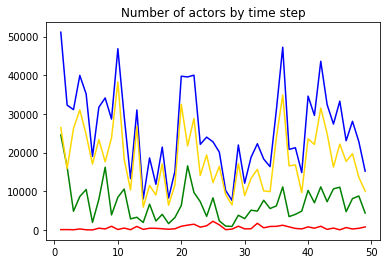

In [ ]:
total_wallets = df_wallets_features_classes_combined.groupby('Time step').count()
illicit_wallets = df_wallets_features_classes_combined[df_wallets_features_classes_combined['class']==1].groupby('Time step').count()
licit_wallets = df_wallets_features_classes_combined[df_wallets_features_classes_combined['class']==2].groupby('Time step').count()
unknown_wallets = df_wallets_features_classes_combined[df_wallets_features_classes_combined['class']==3].groupby('Time step').count()
plt.title('Number of actors by time step')
plt.plot(total_wallets['address'], color='blue')
plt.plot(illicit_wallets['address'], color='red')
plt.plot(licit_wallets['address'], color='green')
plt.plot(unknown_wallets['address'], color='gold')

Distribution of the number of actors by time step:

**Training Set**: Time steps 1 to 34

**Testing Set**: Time steps 35 to 49

In [ ]:
grouped_class = df_wallets_features_classes_combined[['Time step','class']].groupby(['Time step','class']).size().to_frame().reset_index()

timesteps = list(range(1,50))

fig = go.Figure(data = [
    go.Bar(name="Unknown (unlabelled)",x=timesteps,y=grouped_class[grouped_class['class'] == 3][0],marker = dict(color = 'orange', line = dict(color = 'orange',width=1))),
    go.Bar(name="Licit (non-fraud)",x=timesteps,y=grouped_class[grouped_class['class'] == 2][0],marker = dict(color = 'green', line = dict(color = 'green',width=1))),
    go.Bar(name="Illicit (fraud)",x=timesteps,y=grouped_class[grouped_class['class'] == 1][0],marker = dict(color = 'red', line = dict(color = 'red',width=1)))
])

fig.update_layout(barmode='stack')

Numerical distribution of the number of actors of each class by time step:
<br>

<br>

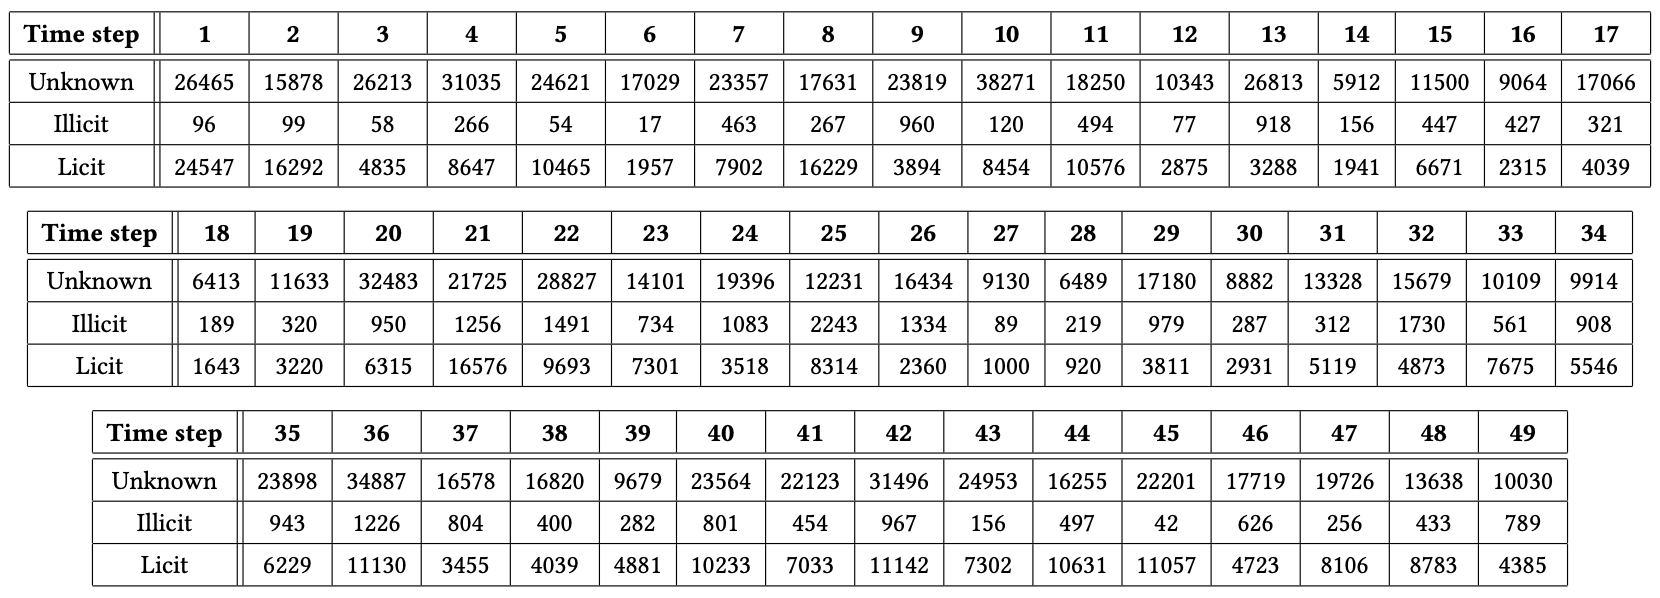

In [ ]:
unknown_count = grouped_class[grouped_class['class'] == 3]
illicit_count = grouped_class[grouped_class['class'] == 1]
licit_count = grouped_class[grouped_class['class'] == 2]

frames = [unknown_count, illicit_count, licit_count]
df_count_distribution = pd.concat(frames)
df_count_distribution.rename(columns={0: 'counts'}).sort_values('Time step')

,Time step,class,counts
2,1,3,26465
0,1,1,96
1,1,2,24547
5,2,3,15878
3,2,1,99
...,...,...,...
143,48,3,13638
141,48,1,433
144,49,1,789
146,49,3,10030


Distribution of the number of illicit actors (that appear in 1, 2 − 4, and ≥ 5 time steps) by time step:
<br>



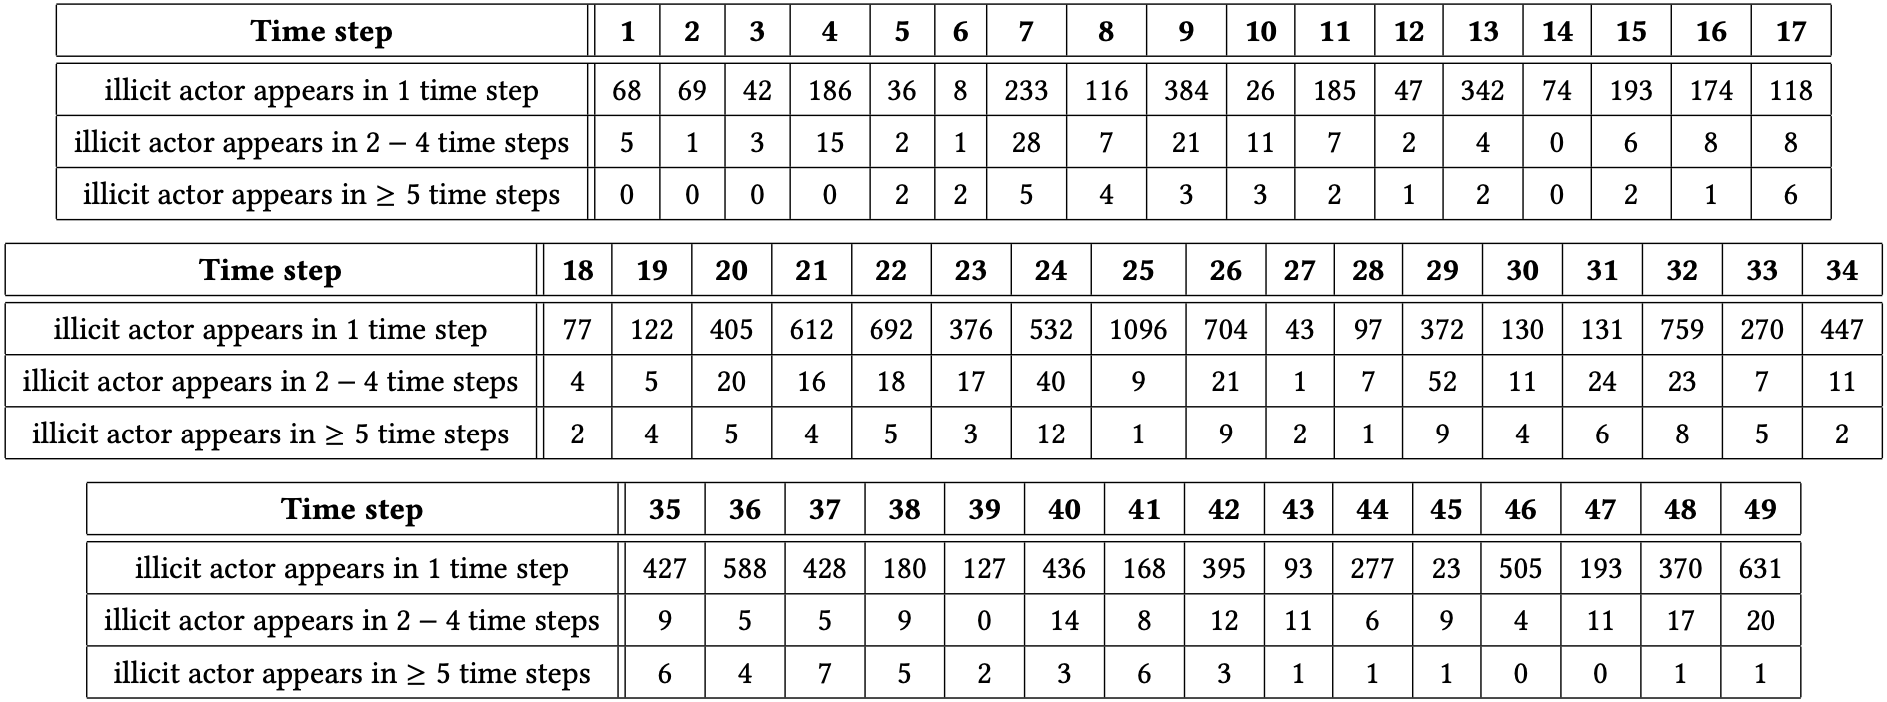

In [ ]:
illicit_actors_1_timestep = pd.DataFrame(df_wallets_features_classes_combined[(df_wallets_features_classes_combined['class']==1) & (df_wallets_features_classes_combined['num_timesteps_appeared_in']==1)].drop_duplicates().groupby('Time step').count()['num_timesteps_appeared_in'])
illicit_actors_2_to_4_timestep = pd.DataFrame(df_wallets_features_classes_combined[(df_wallets_features_classes_combined['class']==1) & (df_wallets_features_classes_combined['num_timesteps_appeared_in']>=2) & (df_wallets_features_classes_combined['num_timesteps_appeared_in']<=4)].drop_duplicates().groupby('Time step').count()['num_timesteps_appeared_in'])
illicit_actors_greater_5_timestep = pd.DataFrame(df_wallets_features_classes_combined[(df_wallets_features_classes_combined['class']==1) & (df_wallets_features_classes_combined['num_timesteps_appeared_in']>=5)].drop_duplicates().groupby('Time step').count()['num_timesteps_appeared_in'])

df_illicit_actors_distribution = pd.concat([illicit_actors_1_timestep, illicit_actors_2_to_4_timestep, illicit_actors_greater_5_timestep], axis=1).fillna(0)
df_illicit_actors_distribution.columns.values[0] = 'in_1_timestep'
df_illicit_actors_distribution.columns.values[1] = 'in_2_to_4_timestep'
df_illicit_actors_distribution.columns.values[2] = 'in_greater_5_timestep'
df_illicit_actors_distribution

,in_1_timestep,in_2_to_4_timestep,in_greater_5_timestep
Time step,,,
1,68,5.0,0.0
2,69,1.0,0.0
3,42,3.0,0.0
4,186,15.0,0.0
5,36,2.0,2.0
6,8,1.0,2.0
7,233,28.0,5.0
8,116,7.0,4.0
9,384,21.0,3.0


Illicit actor statistics:

All illicit actors appearing in ≥ 5 time steps:

In [ ]:
illicit_actors_greater_5 = df_wallets_features_classes_combined[(df_wallets_features_classes_combined['num_timesteps_appeared_in']>=5) & (df_wallets_features_classes_combined['class']==1)]
illicit_actors_greater_5

,address,Time step,class,num_txs_as_sender,num_txs_as receiver,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks,total_txs,first_sent_block,...,blocks_btwn_output_txs_min,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median
32411,12ccSQ7vJZTXgQRkyVwTQGhFKaiqK14uAw,11,1,0.0,5.0,411364.0,487969.0,76605.0,5.0,0.0,...,8064.0,34270.0,19151.25,17135.5,0.0,16.0,1.0,1.0,1.0,1.0
32412,12ccSQ7vJZTXgQRkyVwTQGhFKaiqK14uAw,15,1,0.0,5.0,411364.0,487969.0,76605.0,5.0,0.0,...,8064.0,34270.0,19151.25,17135.5,0.0,16.0,1.0,1.0,1.0,1.0
32413,12ccSQ7vJZTXgQRkyVwTQGhFKaiqK14uAw,32,1,0.0,5.0,411364.0,487969.0,76605.0,5.0,0.0,...,8064.0,34270.0,19151.25,17135.5,0.0,16.0,1.0,1.0,1.0,1.0
32414,12ccSQ7vJZTXgQRkyVwTQGhFKaiqK14uAw,41,1,0.0,5.0,411364.0,487969.0,76605.0,5.0,0.0,...,8064.0,34270.0,19151.25,17135.5,0.0,16.0,1.0,1.0,1.0,1.0
32415,12ccSQ7vJZTXgQRkyVwTQGhFKaiqK14uAw,49,1,0.0,5.0,411364.0,487969.0,76605.0,5.0,0.0,...,8064.0,34270.0,19151.25,17135.5,0.0,16.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266743,3QqF1iHxztxRLWtsaoWSnWcPcUAZSJDJfM,24,1,0.0,6.0,405324.0,473866.0,68542.0,6.0,0.0,...,1.0,32244.0,13708.40,10083.0,0.0,11.0,1.0,1.0,1.0,1.0
1266744,3QqF1iHxztxRLWtsaoWSnWcPcUAZSJDJfM,26,1,0.0,6.0,405324.0,473866.0,68542.0,6.0,0.0,...,1.0,32244.0,13708.40,10083.0,0.0,11.0,1.0,1.0,1.0,1.0
1266745,3QqF1iHxztxRLWtsaoWSnWcPcUAZSJDJfM,31,1,0.0,6.0,405324.0,473866.0,68542.0,6.0,0.0,...,1.0,32244.0,13708.40,10083.0,0.0,11.0,1.0,1.0,1.0,1.0
1266746,3QqF1iHxztxRLWtsaoWSnWcPcUAZSJDJfM,42,1,0.0,6.0,405324.0,473866.0,68542.0,6.0,0.0,...,1.0,32244.0,13708.40,10083.0,0.0,11.0,1.0,1.0,1.0,1.0


Total number of illicit actors that transact in >= 5 time steps:

In [ ]:
print("Number of illicit actors that transact in >= 5 time steps: \n", len([*set(illicit_actors_greater_5['address'].values)]))

print("\nAddresses and number of time steps they appear in: \n")
illicit_actors_greater_5[['address', 'num_timesteps_appeared_in']].drop_duplicates()

Number of illicit actors that transact in >= 5 time steps: 
 23

Addresses and number of time steps they appear in: 



,address,num_timesteps_appeared_in
32411,12ccSQ7vJZTXgQRkyVwTQGhFKaiqK14uAw,5.0
38525,12k7kXAo7JjcHTnoPxpYsYQRVDAZaM4Jfq,10.0
99464,141Zu4pHzkYZefE2audb1FU1gRkJ1TNKT6,8.0
560458,1DoJZfdNJ6vPTKnGeMaoeasNThpptNP1L1,5.0
661132,1FvtWwP3ePJDeR6K7ZePGujUuusUTds8Vy,7.0
682676,1GQSnzh9JRgipxC7btKvD3rBS8Zj8SVnAo,15.0
710912,1GznpZnvSmnXyWFLHUXAX3oSwARvrnZD1G,5.0
717335,1H91HHDt3bEgv3zHk1GqXYnkANJfjHLSZC,6.0
746404,1Hmm1KKPDUnwzZjRLSRPtVtTYe2KrEE4U3,10.0
813624,1KD6iM6HxWc2UvY9ZK1vZEcQUidmoDxHFB,6.0


Mapping above addresses to each "Illicit Actor" in the paper:

Illict Actor 1 - 1GQSnzh9JRgipxC7btKvD3rBS8Zj8SVnAo
<br>
Illicit Actor 2 - 12k7kXAo7JjcHTnoPxpYsYQRVDAZaM4Jfq
<br>
Illicit Actor 3 - 1Hmm1KKPDUnwzZjRLSRPtVtTYe2KrEE4U3
<br>
Illicit Actor 4 - 3LAr1LEZra3sCW15Z2s6pHN4WSoTWfkWYU
<br>
Illicit Actor 5 - 141Zu4pHzkYZefE2audb1FU1gRkJ1TNKT6
<br>
Illicit Actor 6 - 3NLyzZRyEMmwsASjT88NnYHotkCxkjw4oT
<br>
Illicit Actor 7 - 3Q6vpPnVByYUibeDLUYMD2ExuMsErzYFxw
<br>
Illicit Actor 8 - 1FvtWwP3ePJDeR6K7ZePGujUuusUTds8Vy
<br>
Illicit Actor 9 - 1H91HHDt3bEgv3zHk1GqXYnkANJfjHLSZC
<br>
Illicit Actor 10 - 3FwbDmgmvazTUZyyqCF94rKZBw5XnXjFxY
<br>
Illicit Actor 11 - 1KD6iM6HxWc2UvY9ZK1vZEcQUidmoDxHFB
<br>
Illicit Actor 12 - 1KNd3pk9M2W2K92UVY7o1XxCypRseQfVam
<br>
Illicit Actor 13 - 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
<br>
Illicit Actor 14 - 3MbiUzrxs7tkpBZa57iCh3L2yvdCHTTDNf
<br>
Illicit Actor 15 - 3PeQneikMXY42tGPXojDd5jb88MWyfuCTZ

Example - Illicit Actor 1's transactions:

In [ ]:
illicit_1 = illicit_actors_greater_5[illicit_actors_greater_5['address']=='1GQSnzh9JRgipxC7btKvD3rBS8Zj8SVnAo']
illicit_1

,address,Time step,class,num_txs_as_sender,num_txs_as receiver,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks,total_txs,first_sent_block,...,blocks_btwn_output_txs_min,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median
682676,1GQSnzh9JRgipxC7btKvD3rBS8Zj8SVnAo,24,1,35.0,33.0,437582.0,477896.0,40314.0,68.0,453703.0,...,0.0,8056.0,1260.09375,4.5,1.0,103.0,1.0,2.0,1.009804,1.0
682677,1GQSnzh9JRgipxC7btKvD3rBS8Zj8SVnAo,28,1,35.0,33.0,437582.0,477896.0,40314.0,68.0,453703.0,...,0.0,8056.0,1260.09375,4.5,1.0,103.0,1.0,2.0,1.009804,1.0
682678,1GQSnzh9JRgipxC7btKvD3rBS8Zj8SVnAo,29,1,35.0,33.0,437582.0,477896.0,40314.0,68.0,453703.0,...,0.0,8056.0,1260.09375,4.5,1.0,103.0,1.0,2.0,1.009804,1.0
682679,1GQSnzh9JRgipxC7btKvD3rBS8Zj8SVnAo,30,1,35.0,33.0,437582.0,477896.0,40314.0,68.0,453703.0,...,0.0,8056.0,1260.09375,4.5,1.0,103.0,1.0,2.0,1.009804,1.0
682680,1GQSnzh9JRgipxC7btKvD3rBS8Zj8SVnAo,32,1,35.0,33.0,437582.0,477896.0,40314.0,68.0,453703.0,...,0.0,8056.0,1260.09375,4.5,1.0,103.0,1.0,2.0,1.009804,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682739,1GQSnzh9JRgipxC7btKvD3rBS8Zj8SVnAo,43,1,35.0,33.0,437582.0,477896.0,40314.0,68.0,453703.0,...,0.0,8056.0,1260.09375,4.5,1.0,103.0,1.0,2.0,1.009804,1.0
682740,1GQSnzh9JRgipxC7btKvD3rBS8Zj8SVnAo,44,1,35.0,33.0,437582.0,477896.0,40314.0,68.0,453703.0,...,0.0,8056.0,1260.09375,4.5,1.0,103.0,1.0,2.0,1.009804,1.0
682741,1GQSnzh9JRgipxC7btKvD3rBS8Zj8SVnAo,44,1,35.0,33.0,437582.0,477896.0,40314.0,68.0,453703.0,...,0.0,8056.0,1260.09375,4.5,1.0,103.0,1.0,2.0,1.009804,1.0
682742,1GQSnzh9JRgipxC7btKvD3rBS8Zj8SVnAo,44,1,35.0,33.0,437582.0,477896.0,40314.0,68.0,453703.0,...,0.0,8056.0,1260.09375,4.5,1.0,103.0,1.0,2.0,1.009804,1.0


Illicit Actor 1's transactions per time step (appears in 15 time steps):

In [ ]:
Counter(illicit_1['Time step'])

Counter({24: 1,
         28: 1,
         29: 1,
         30: 1,
         32: 2,
         33: 2,
         34: 1,
         35: 10,
         36: 11,
         37: 1,
         39: 1,
         41: 15,
         42: 15,
         43: 2,
         44: 4})

Bitcoin user entity statistics:

The total number of Bitcoin user entities in the dataset:

In [ ]:
df_AddrTx_edgelist_temp = df_AddrTx_edgelist
df_AddrTx_edgelist_temp = df_AddrTx_edgelist_temp.groupby('txId')['input_address'].apply(list)

l = df_AddrTx_edgelist_temp

def to_graph(l):
    G = nx.Graph()
    for part in l:
        # each sublist is a bunch of nodes
        G.add_nodes_from(part)
        # it also imlies a number of edges:
        G.add_edges_from(to_edges(part))
    return G

def to_edges(l):
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current    

G = to_graph(l)
all_components = nx.connected_components(G)
num_components = nx.number_connected_components(G)
print("Number of Bitcoin users: \n", num_components)

Number of Bitcoin users: 
 146783


In [ ]:
from pandas.core.arrays.interval import value_counts
from statistics import mean, median

<class 'map'>


In [ ]:
list_components = list(map(lambda x: len(x), all_components))
print("\nMinimum number of addresses per User: \n", min(list_components))
print("\nMedian number of addresses per User: \n", median(list_components))
print("\nMean number of addresses per User: \n", mean(list_components))
print("\nMax number of addresses per User: \n", max(list_components))


Minimum number of addresses per User: 
 1

Median number of addresses per User: 
 1

Mean number of addresses per User: 
 2.726555527547468

Max number of addresses per User: 
 14885


Each individual user entity is a row, the column indicates the number of addresses that belong to that user entity:

In [ ]:
df_users = pd.DataFrame (list_components)
df_users.rename(columns={0: "num_addresses_of_user"})

,num_addresses_of_user
0,2
1,3
2,1
3,1
4,1
...,...
146778,1
146779,1
146780,1
146781,1


Feature analysis, some features show good correlation (Fees_SHARE (total), BTC_RECEIVED (MAX), Block_FIRST SENT, ADDR_INTERACTION (total)) while some features show bad correlation (Fees_SHARE (MEAN), Fees_SHARE (MEDIAN), ADDR_INTERACTION (MIN), ADDR_INTERACTION (Median)):


Features showing good correlation for classification and explainability : 



<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'fees_as_share_total')

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'btc_received_max')

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'first_sent_block')

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'transacted_w_address_total')

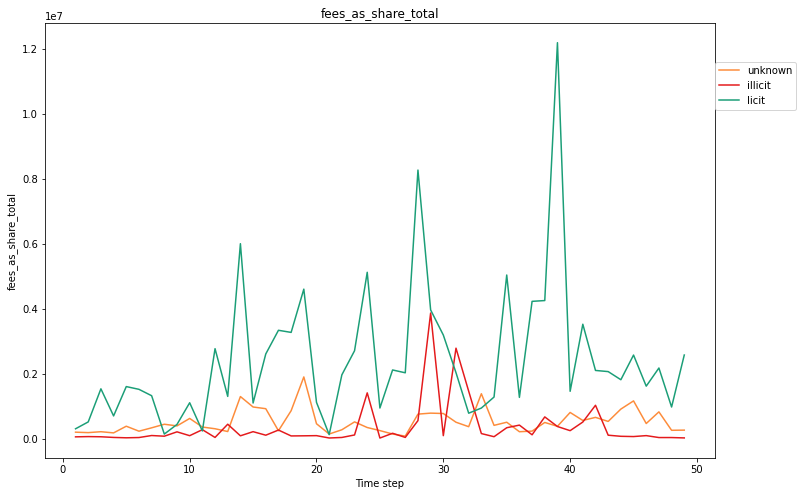

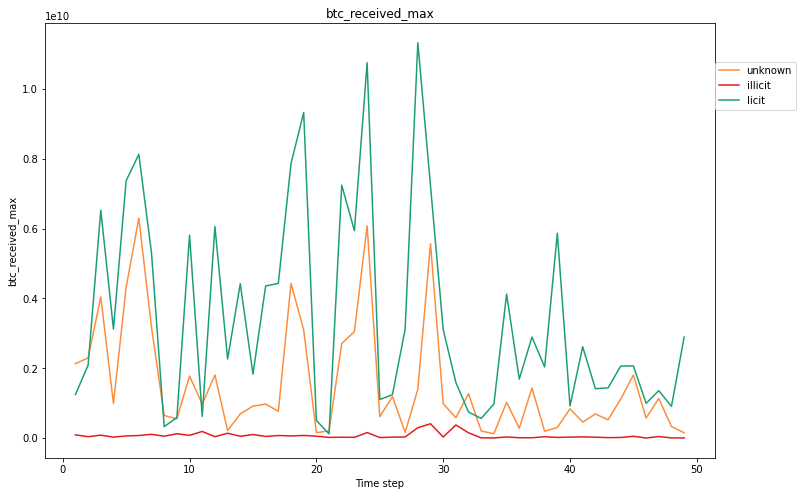

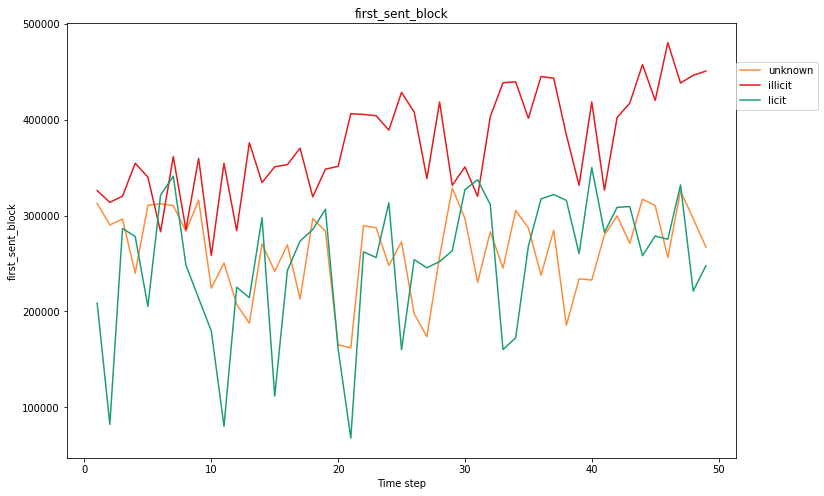

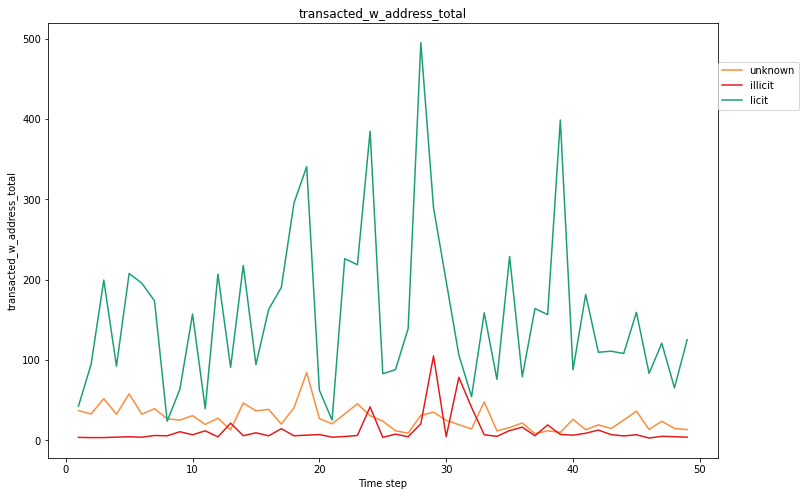

In [ ]:
print("\nFeatures showing good correlation for classification and explainability : \n")

good_correlation_features = ['fees_as_share_total', 'btc_received_max', 'first_sent_block', 'transacted_w_address_total']

for feat in good_correlation_features:
  plt.figure(figsize=(12, 8))
  grouped = df_wallets_features_classes_combined.groupby(['Time step', 'class'])[feat].mean().reset_index()
  grouped.loc[grouped['class'] == 1, 'class'] = 'illicit'
  grouped.loc[grouped['class'] == 2, 'class'] = 'licit'
  grouped.loc[grouped['class'] == 3, 'class'] = 'unknown'
  sns.lineplot(x='Time step', y=feat, hue='class', data=grouped[grouped['class']=='unknown'], palette='Oranges');
  sns.lineplot(x='Time step', y=feat, hue='class', data=grouped[grouped['class']=='illicit'], palette='Set1');
  sns.lineplot(x='Time step', y=feat, hue='class', data=grouped[grouped['class']=='licit'], palette='Dark2');
  plt.legend(loc=(1.0, 0.8));
  plt.title(feat);


Features showing bad correlation for classification and explainability : 



<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'fees_as_share_mean')

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'fees_as_share_median')

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'transacted_w_address_min')

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'transacted_w_address_median')

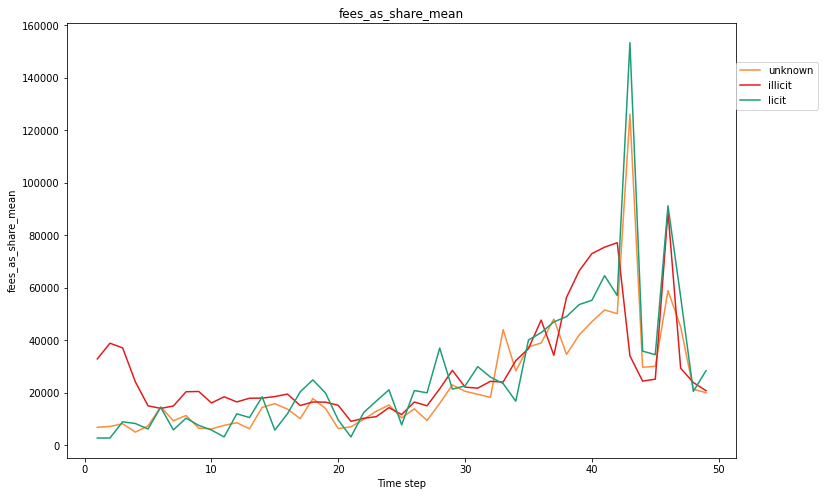

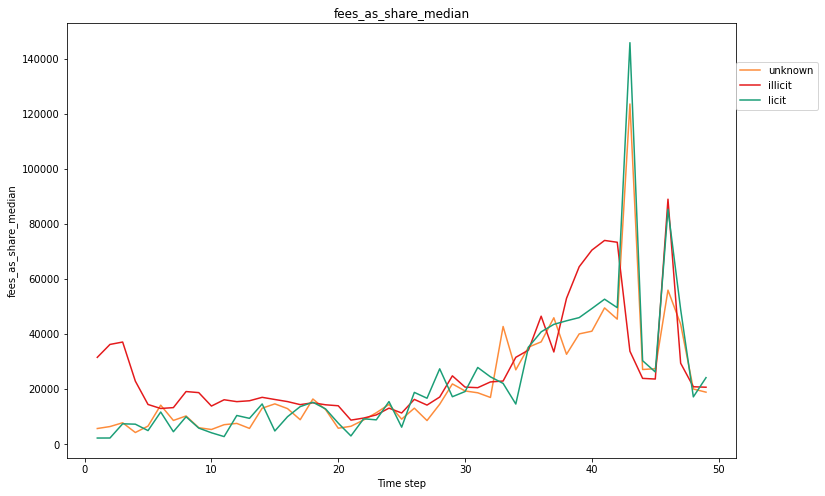

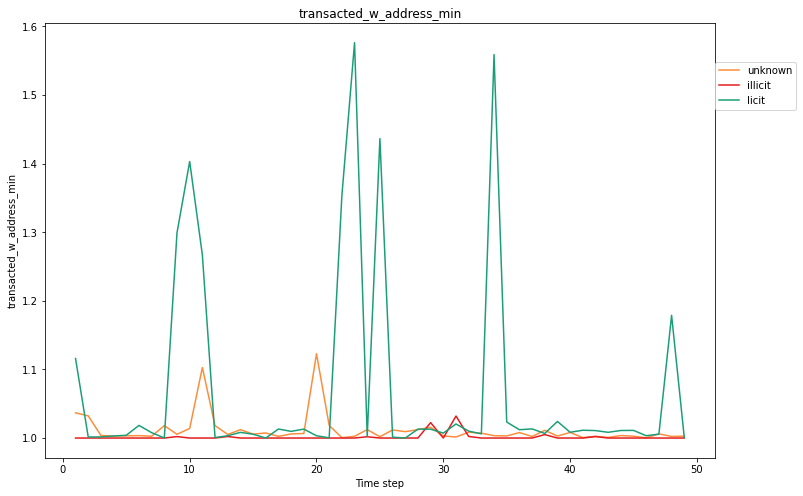

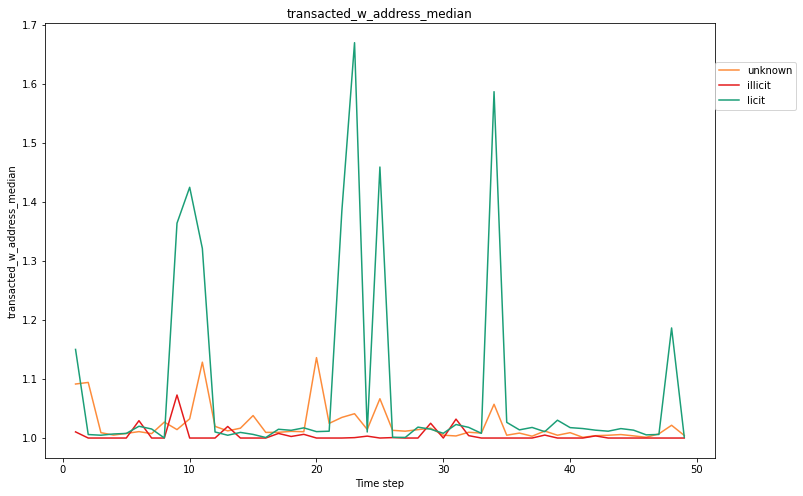

In [ ]:
print("\nFeatures showing bad correlation for classification and explainability : \n")

bad_correlation_features = ['fees_as_share_mean', 'fees_as_share_median', 'transacted_w_address_min', 'transacted_w_address_median']

for feat in bad_correlation_features:
  plt.figure(figsize=(12, 8))
  grouped = df_wallets_features_classes_combined.groupby(['Time step', 'class'])[feat].mean().reset_index()
  grouped.loc[grouped['class'] == 1, 'class'] = 'illicit'
  grouped.loc[grouped['class'] == 2, 'class'] = 'licit'
  grouped.loc[grouped['class'] == 3, 'class'] = 'unknown'
  sns.lineplot(x='Time step', y=feat, hue='class', data=grouped[grouped['class']=='unknown'], palette='Oranges');
  sns.lineplot(x='Time step', y=feat, hue='class', data=grouped[grouped['class']=='illicit'], palette='Set1');
  sns.lineplot(x='Time step', y=feat, hue='class', data=grouped[grouped['class']=='licit'], palette='Dark2');
  plt.legend(loc=(1.0, 0.8));
  plt.title(feat);

# **Acknowledgements**


---
---


Released by: Youssef Elmougy, Ling Liu



School of Computer Science, Georgia Institute of Technology

Contact: yelmougy3@gatech.edu


---

Github Repository: [https://www.github.com/git-disl/EllipticPlusPlus](https://www.github.com/git-disl/EllipticPlusPlus)


If you use our dataset in your work, please cite our paper:





>> Youssef Elmougy and Ling Liu. 2023. Demystifying Fraudulent Transactions and Illicit Nodes in the Bitcoin Network for Financial Forensics.

---

